In [1]:
import os
import sys
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
base_dir = os.path.join("/home/jovyan/work/Corona/COVID-19")
sys.path.append(base_dir)
import model as md

In [2]:
def print_overview(merger):
    check_df = merger.df["details"].copy()
    check_df["additional.infected_7"] = check_df["cumulated.infected"]-check_df["cumulated.infected"].shift(periods=7)
    check_df["incidence"] = check_df["additional.infected_7"]/9660350*100000
    prv_active = check_df[-2:-1]["active.infected"].mean()
    act_active = check_df[-1:]["active.infected"].mean()
    print("Delta active infected:", act_active-prv_active)
    act_new = check_df[-1:]["additional.infected"].mean()
    act_deaths = check_df[-1:]["additional.deaths"].mean()
    prv_recover = check_df[-2:-1]["cumulated.recoveredFromHospital"].mean()
    act_recover = check_df[-1:]["cumulated.recoveredFromHospital"].mean()
    print("New infected - delta deaths - delta all recover:", act_new-act_deaths-(act_recover-prv_recover))
    return check_df[[
        "date", 
        "additional.infected",
        "cumulated.infected",
        "additional.infected_7",
        "incidence"
    ]].tail(20)

In [3]:
merger = md.Merger(data_dir="data", load_from_raw=False, load_from_agg=True)

Delta active infected: -1110.0
New infected - delta deaths - delta all recover: -1110.0


,date,additional.infected,cumulated.infected,additional.infected_7,incidence
482,2021-07-09,44.0,808437,309.0,3.198642
483,2021-07-12,102.0,808539,379.0,3.923253
484,2021-07-13,17.0,808556,359.0,3.716221
485,2021-07-14,56.0,808612,350.0,3.623057
486,2021-07-15,49.0,808661,367.0,3.799034
487,2021-07-16,64.0,808725,387.0,4.006066
488,2021-07-19,139.0,808864,471.0,4.875600
489,2021-07-20,25.0,808889,452.0,4.678920
490,2021-07-21,56.0,808945,406.0,4.202746
491,2021-07-22,71.0,809016,460.0,4.761732


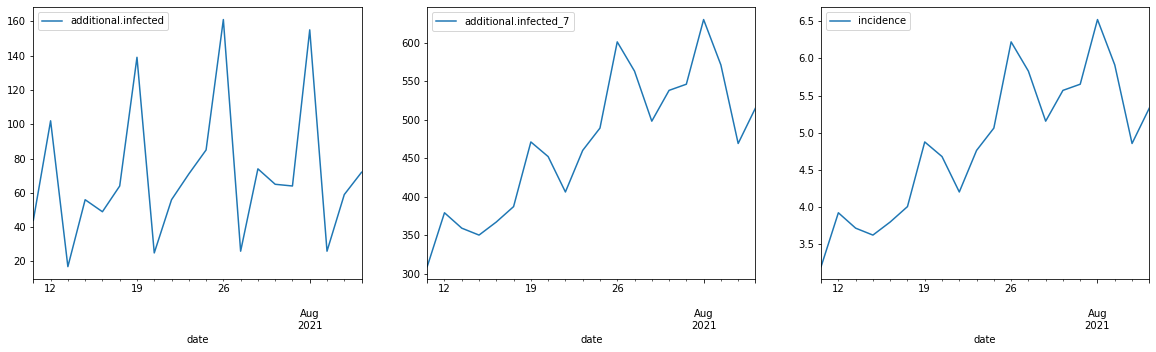

In [4]:
review_df = print_overview(merger)
fig, ax = plt.subplots(figsize=(20,5), ncols=3)
review_df.plot(x="date", y="additional.infected", ax=ax[0])
review_df.plot(x="date", y="additional.infected_7", ax=ax[1])
review_df.plot(x="date", y="incidence", ax=ax[2])
review_df

In [5]:
# merger.convert_deaths_df()
df = merger.merge_deaths_df()

In [6]:
df_additional = merger.df["details"][["date","additional.infected"]].set_index("date")

In [7]:
df_tests = merger.show_kpi_hu()[["tests"]].reset_index()
df_tests["index"] = pd.to_datetime(df_tests["index"], format='%Y-%m-%d').dt.date
df_tests["additional.tests"] = df_tests.apply(
    lambda row: row["tests"]-df_tests[
        df_tests["index"]==row["index"] - pd.Timedelta(1, unit='D')
    ]["tests"].max(), 
    axis=1
)
df_tests = df_tests.set_index("index")

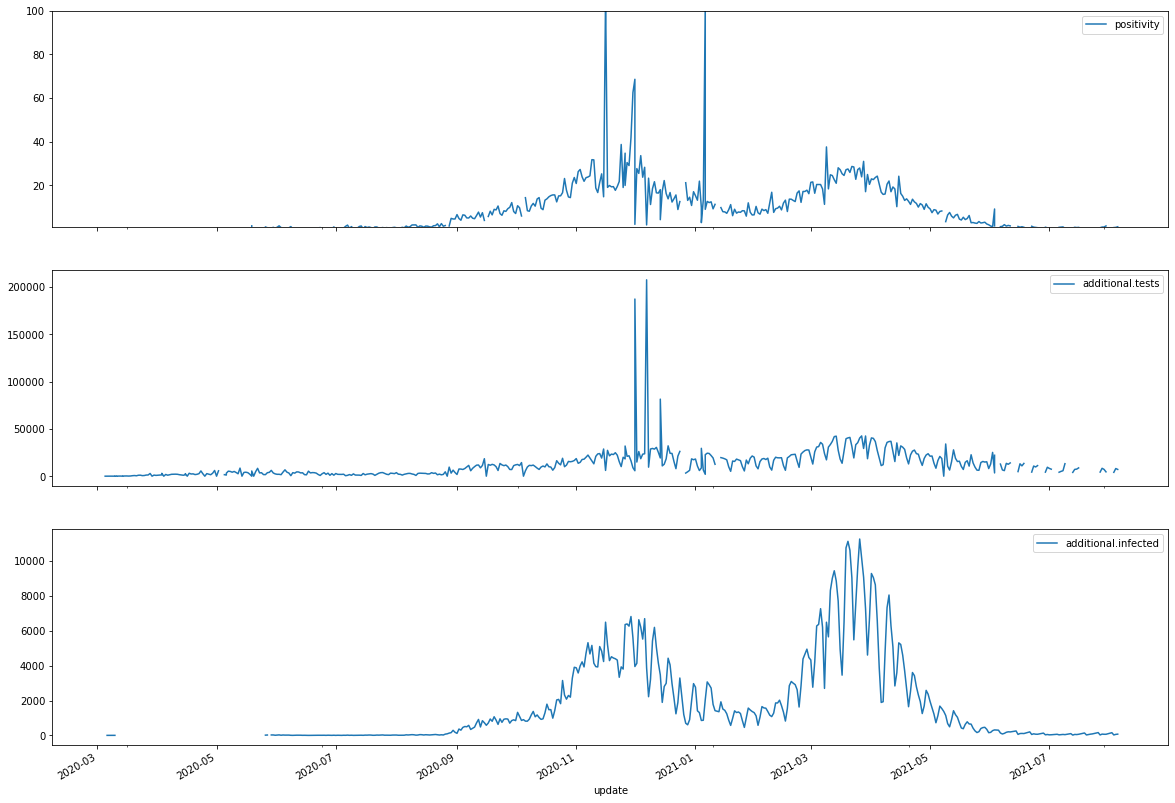

In [8]:
df_join = df_tests.join(df_additional).reset_index()
df_join["positivity"] = df_join["additional.infected"]/df_join["additional.tests"]*100
df_join["Country/Region"] = "HU"
df_join["update"] = df_join["index"]
(fig, ax) = plt.subplots(figsize=(20,15), nrows=3, sharex=True)
ax[0].set_ylim(1,100)
df_join.plot(x="update", y="positivity", ax=ax[0])
df_join.plot(x="update", y="additional.tests", ax=ax[1])
df_join.plot(x="update", y="additional.infected", ax=ax[2])
plt.show()

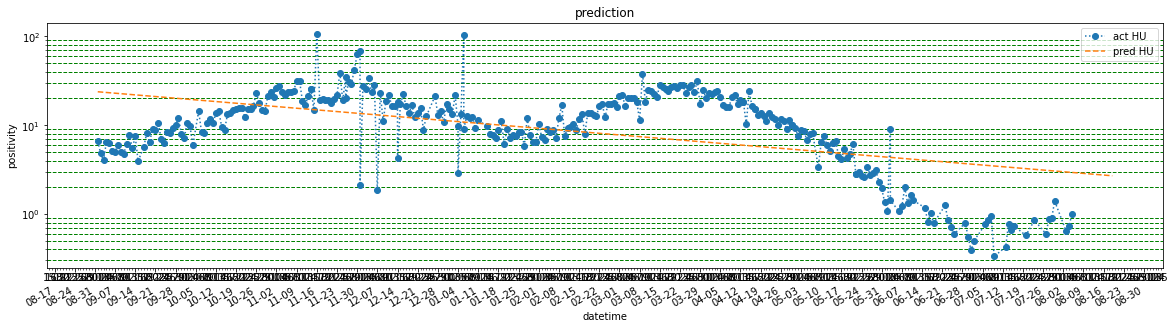

Coefficient of determination: {'HU': 0.27790482200023003}
Evolution factor per day: {'HU': 1.0}
Doubling in day(s): {'HU': 2.0}


,index,tests,additional.tests,additional.infected,positivity,Country/Region,update
544,2021-07-30,6328373.0,4580.0,64.0,1.397380,HU,2021-07-30
545,2021-08-02,6348148.0,NaN,155.0,NaN,HU,2021-08-02
546,2021-08-03,6352215.0,4067.0,26.0,0.639292,HU,2021-08-03
547,2021-08-04,6360304.0,8089.0,59.0,0.729386,HU,2021-08-04
548,2021-08-05,6367442.0,7138.0,72.0,1.008686,HU,2021-08-05


In [9]:
tmpDf = md.DataProcessing.Analyse.start_analyse(
    df_join[
        (df_join["additional.tests"]>0) & (df_join["index"]>=pd.Timestamp("2020-09-01"))
    ].dropna(),
    ["HU"],
    "positivity", 
    "positivity"
)
df_join.tail()

# Check plausibility

In [10]:
# Details
selected_details_df = merger.df["details"][[
    "date", "additional.infected", "additional.deaths", 
    "cumulated.infected", "cumulated.recoveredFromHospital", 
    "onVentilator", "hospital", "active.infected"
]].copy()
selected_details_df.columns = [
    "date", "news.add.infected", "news.add.deaths", 
    "news.cum.infected", "news.cum.recovered", 
    "news.onVentilator", "news.hospital", "news.active"
]
selected_details_df["date"] = pd.to_datetime(selected_details_df["date"], format='%Y-%m-%d').dt.date
selected_details_df["news.add.recovered"] = selected_details_df.apply(
    lambda row: row["news.cum.recovered"] - selected_details_df[
        selected_details_df["date"]<row["date"]
    ]["news.cum.recovered"].max(), axis=1
)
selected_details_df = selected_details_df.set_index("date")

# KPI
selected_kpi_df = merger.show_kpi_hu()[["infected"]].copy().reset_index()
selected_kpi_df.columns = ["date", "kpi.cum.infected"]
selected_kpi_df["date"] = pd.to_datetime(selected_kpi_df["date"], format='%Y-%m-%d').dt.date
selected_kpi_df = selected_kpi_df.set_index("date")

selected_details_df.join(selected_kpi_df).tail()

,news.add.infected,news.add.deaths,news.cum.infected,news.cum.recovered,news.onVentilator,news.hospital,news.active,news.add.recovered,kpi.cum.infected
date,,,,,,,,,
2021-07-30,64.0,1.0,809491,748157.0,11.0,78.0,31308.0,645.0,809491.0
2021-08-02,155.0,1.0,809646,749185.0,11.0,76.0,32434.0,1028.0,809646.0
2021-08-03,26.0,2.0,809672,749461.0,10.0,77.0,30182.0,276.0,809672.0
2021-08-04,59.0,3.0,809731,749773.0,8.0,82.0,29926.0,312.0,809731.0
2021-08-05,72.0,0.0,809803,750955.0,11.0,79.0,28816.0,1182.0,809803.0


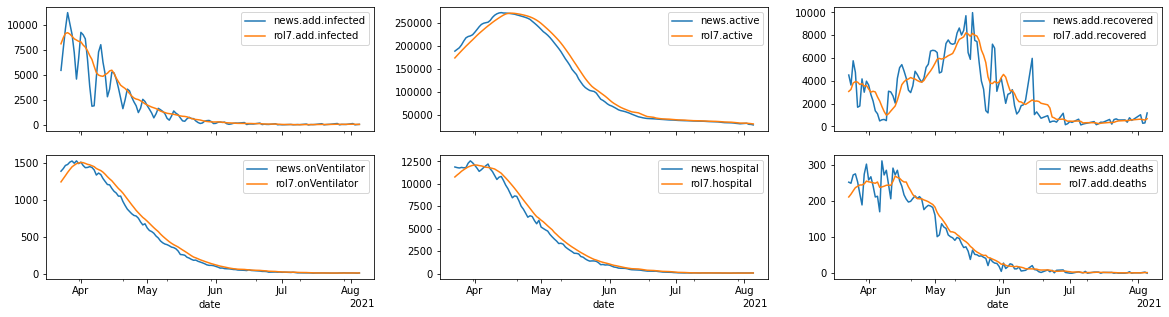

In [11]:
(fig, axs) = plt.subplots(figsize=(20,5), nrows=2, ncols=3, sharex=True)
plot_df = selected_details_df
configuration = {
    "add.infected":(0, 0), "onVentilator":(1,0),   # 1st col
    "active":(0,1),        "hospital":(1,1),       # 2nd col
    "add.recovered":(0,2), "add.deaths":(1,2)      # 3rd col
}
for category in configuration:
    plot_df["rol7.{}".format(category)] = plot_df.rolling(7).mean()[[f"news.{category}"]]
plot_df = plot_df.reset_index().tail(120)

locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
for (category, position) in configuration.items():
    my_ax = axs[position[0]][position[1]]
    my_ax.xaxis.set_major_locator(locator)
    my_ax.xaxis.set_major_formatter(formatter)
    plot_df.plot(x="date", y="news.{}".format(category), ax=my_ax)
    plot_df.plot(x="date", y="rol7.{}".format(category), ax=my_ax)
plt.show()

In [12]:
#plot_df["add.infected"] = plot_df.apply(lambda row: plot_df[plot_df["date"]<], axis=1)
#plot_df.head()
plot_df.tail(10)

,date,news.add.infected,news.add.deaths,news.cum.infected,news.cum.recovered,news.onVentilator,news.hospital,news.active,news.add.recovered,rol7.add.infected,rol7.onVentilator,rol7.active,rol7.hospital,rol7.add.recovered,rol7.add.deaths
492,2021-07-23,85.0,0.0,809101,745277.0,9.0,67.0,33804.0,563.0,69.857143,10.000000,35205.714286,75.285714,483.000000,1.000000
493,2021-07-26,161.0,0.0,809262,745848.0,9.0,55.0,33394.0,571.0,85.857143,10.000000,34779.428571,71.285714,511.142857,1.000000
494,2021-07-27,26.0,1.0,809288,746219.0,11.0,73.0,33048.0,371.0,80.428571,10.142857,34346.571429,69.428571,512.428571,0.857143
495,2021-07-28,74.0,4.0,809362,746981.0,11.0,70.0,32356.0,762.0,71.142857,10.142857,33882.857143,68.571429,533.714286,1.142857
496,2021-07-29,65.0,0.0,809427,747512.0,13.0,79.0,31890.0,531.0,76.857143,10.428571,33378.428571,68.857143,580.428571,0.857143
497,2021-07-30,64.0,1.0,809491,748157.0,11.0,78.0,31308.0,645.0,78.000000,10.571429,32868.857143,69.142857,586.571429,1.000000
498,2021-08-02,155.0,1.0,809646,749185.0,11.0,76.0,32434.0,1028.0,90.000000,10.714286,32604.857143,71.142857,638.714286,1.000000
499,2021-08-03,26.0,2.0,809672,749461.0,10.0,77.0,30182.0,276.0,81.571429,10.857143,32087.428571,72.571429,597.714286,1.285714
500,2021-08-04,59.0,3.0,809731,749773.0,8.0,82.0,29926.0,312.0,67.000000,10.714286,31592.000000,76.428571,560.714286,1.714286
501,2021-08-05,72.0,0.0,809803,750955.0,11.0,79.0,28816.0,1182.0,73.571429,10.714286,30987.428571,77.285714,676.571429,1.571429


In [13]:
baseDf = pd.read_csv("data/map_data/map_dataframe_per_megye.csv", delimiter=",")[['date','region','confirmed']]
normDf = pd.read_csv("data/base/base_dataframe_per_megye.csv", delimiter=",")
baseDf = baseDf.merge(normDf, on="region")
# Convert date column and add week/dayofweek
baseDf["date"] =  pd.to_datetime(baseDf["date"], format="%Y-%m-%d")
baseDf["conf_per_100k"] = baseDf["confirmed"]/baseDf["population"]*100000
max_date = baseDf["date"].max()
date_list = [
    max_date - dt.timedelta(days=21),
    max_date - dt.timedelta(days=14),
    max_date - dt.timedelta(days=7),
    max_date
]
last_kpi = baseDf[baseDf["date"].isin(date_list)].pivot(
    index="region",
    columns="date",
    values="conf_per_100k"
)
last_kpi.columns = ["d-21", "d-14", "d-7", "d"]
last_kpi["w_2"] = last_kpi["d-14"] - last_kpi["d-21"]
last_kpi["w_1"] = last_kpi["d-7"] - last_kpi["d-14"]
last_kpi["w_0"] = last_kpi["d"] - last_kpi["d-7"]
last_kpi["+_1.5"] = last_kpi["w_1"] - last_kpi["w_2"]
last_kpi["+_0.5"] = last_kpi["w_0"] - last_kpi["w_1"]
last_kpi = last_kpi.join(normDf.set_index("region")[["population"]])
last_kpi["ok"] = 50
last_kpi["hum"] = 100
last_kpi["warning"] = 250
last_kpi["alert"] = 500

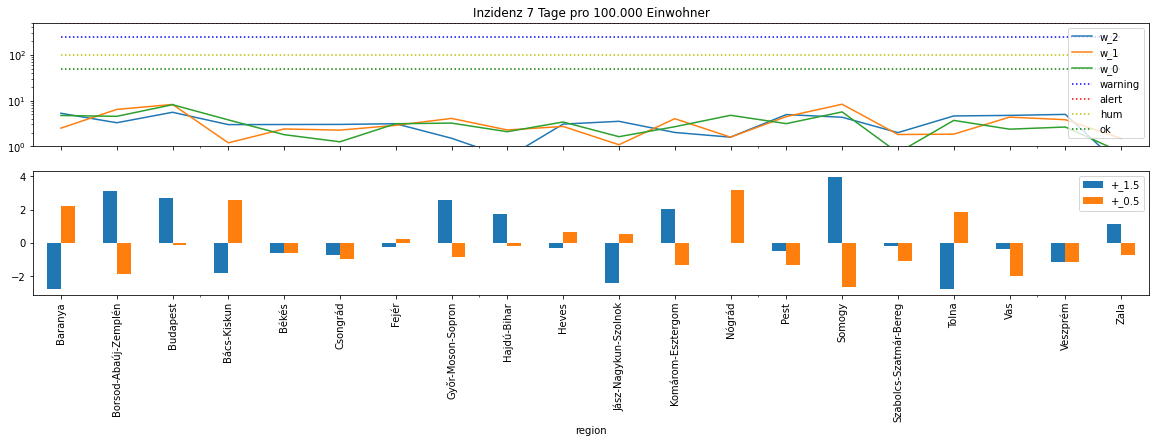

In [14]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20,5), sharex=True)
ax[0].set_title("Inzidenz 7 Tage pro 100.000 Einwohner")
#> 500 – 1.000
#> 250 – 500
#> 100 – 250
#> 50 – 100
#> 25 – 50
#> 5 – 25
#> 0 – 5

last_kpi.plot.line(y=["w_2","w_1","w_0"], ax=ax[0])
last_kpi.plot.line(y=["warning","alert","hum","ok"], ax=ax[0], style=["b:","r:","y:","g:"])
last_kpi.plot.bar(y=["+_1.5","+_0.5"], ax=ax[1])
ax[0].set_ylim(1, 500)
ax[0].set_yscale("log")
plt.show()

In [15]:
last_kpi["time_serie"] = last_kpi.apply(
    lambda row: [
        row["d-14"]-row["d-21"], 
        row["d-7"]-row["d-14"], 
        row["d"]-row["d-7"]
    ], axis=1
)

def print_limits(ax, x1, x2):
    ax.add_patch(Rectangle((x1, 0), x2-x1, 5, linewidth=1, edgecolor='none', facecolor='#fffccd'))
    ax.add_patch(Rectangle((x1, 5), x2-x1, 20, linewidth=1, edgecolor='none', facecolor='#fff380'))
    ax.add_patch(Rectangle((x1, 25), x2-x1, 25, linewidth=1, edgecolor='none', facecolor='#ffb534'))
    ax.add_patch(Rectangle((x1, 50), x2-x1, 50, linewidth=1, edgecolor='none', facecolor='#d43624'))
    ax.add_patch(Rectangle((x1, 100), x2-x1, 150, linewidth=1, edgecolor='none', facecolor='#951214'))
    ax.add_patch(Rectangle((x1, 250), x2-x1, 250, linewidth=1, edgecolor='none', facecolor='#671212'))
    ax.add_patch(Rectangle((x1, 500), x2-x1, 500, linewidth=1, edgecolor='none', facecolor='#dd0085'))

['Baranya', 'Borsod-Abaúj-Zemplén', 'Budapest', 'Bács-Kiskun', 'Békés', 'Csongrád', 'Fejér', 'Győr-Moson-Sopron', 'Hajdú-Bihar', 'Heves', 'Jász-Nagykun-Szolnok', 'Komárom-Esztergom', 'Nógrád', 'Pest', 'Somogy', 'Szabolcs-Szatmár-Bereg', 'Tolna', 'Vas', 'Veszprém', 'Zala']


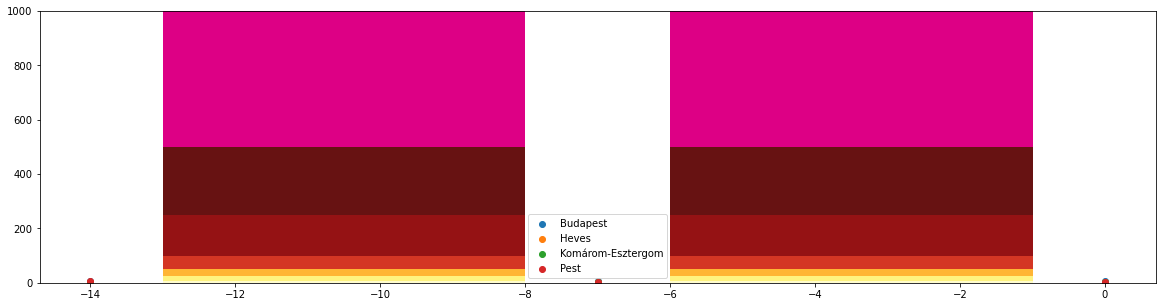

In [16]:
from matplotlib.patches import Rectangle
fig, ax = plt.subplots(figsize=(20,5))
print_limits(ax, -13, -8)
print_limits(ax, -6, -1)
print(list(last_kpi.index))
for region in list(last_kpi.index):
    if region in ["Heves", "Budapest", "Pest", "Komárom-Esztergom"]:
        ax.scatter(x=[-14,-7,0], y=last_kpi.loc[region]["time_serie"], cmap=plt.get_cmap("tab20"), label=region)
ax.set_ylim(0,1000)
ax.legend()
plt.show()

In [17]:
vaccinated_df = merger.df["details"][
    ["date","cumulated.vaccinated","cumulated.vaccinated2"]
].dropna()
vaccinated_df["additional.vaccinated"] = (
    vaccinated_df[["cumulated.vaccinated"]] - vaccinated_df[["cumulated.vaccinated"]].shift(periods=1)
)
vaccinated_df["additional.vaccinated2"] = (
    vaccinated_df[["cumulated.vaccinated2"]] - vaccinated_df[["cumulated.vaccinated2"]].shift(periods=1)
)
vaccinated_df["add.vaccinated_rol7"] = vaccinated_df.rolling(7).sum()[["additional.vaccinated"]]
vaccinated_df["add.vaccinated2_rol7"] = vaccinated_df.rolling(7).sum()[["additional.vaccinated2"]]
vaccinated_df["cumulated.vaccinated2_soll"] = vaccinated_df[["cumulated.vaccinated"]].shift(periods=28)
vaccinated_df[vaccinated_df["date"]<="2021-07-30"].tail()

,date,cumulated.vaccinated,cumulated.vaccinated2,additional.vaccinated,additional.vaccinated2,add.vaccinated_rol7,add.vaccinated2_rol7,cumulated.vaccinated2_soll
493,2021-07-26,5596543.0,5374864.0,8271.0,17353.0,43684.0,124405.0,5363124.0
494,2021-07-27,5600959.0,5390593.0,4416.0,15729.0,41781.0,121779.0,5375923.0
495,2021-07-28,5605713.0,5405781.0,4754.0,15188.0,36614.0,112649.0,5389058.0
496,2021-07-29,5611260.0,5418198.0,5547.0,12417.0,37703.0,106641.0,5411431.0
497,2021-07-30,5617270.0,5428980.0,6010.0,10782.0,39087.0,101655.0,5421230.0


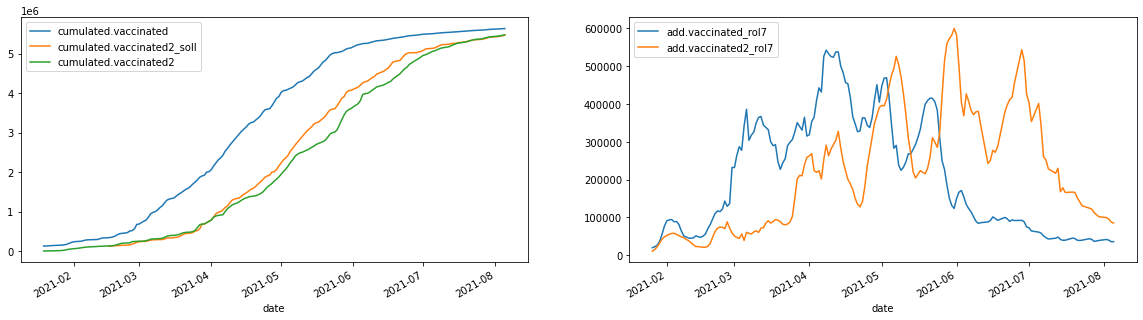

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
vaccinated_df.plot(x="date", y=[
    "cumulated.vaccinated","cumulated.vaccinated2_soll", "cumulated.vaccinated2"
], ax=ax[0])
vaccinated_df.plot(x="date", y=["add.vaccinated_rol7","add.vaccinated2_rol7"], ax=ax[1])
plt.show()

In [19]:
newBaseDf = baseDf.copy()
newBaseDf["date_7d"] = newBaseDf.apply(lambda row: row["date"] - dt.timedelta(days=7), axis=1)
newBaseDf["date_14d"] = newBaseDf.apply(lambda row: row["date"] - dt.timedelta(days=14), axis=1)
newBaseDf["confirmed_7d"] = newBaseDf.apply(
    lambda row: newBaseDf[
        (newBaseDf["date"]==row["date_7d"]) & (newBaseDf["region"]==row["region"])
    ]["confirmed"].max(), 
    axis=1
)
newBaseDf["confirmed_14d"] = newBaseDf.apply(
    lambda row: newBaseDf[
        (newBaseDf["date"]==row["date_14d"]) & (newBaseDf["region"]==row["region"])
    ]["confirmed"].max(), 
    axis=1
)
newBaseDf["incidence_0"] = (newBaseDf["confirmed"]-newBaseDf["confirmed_7d"])/newBaseDf["population"]*100000
newBaseDf["incidence_1"] = (newBaseDf["confirmed_7d"]-newBaseDf["confirmed_14d"])/newBaseDf["population"]*100000
newBaseDf["delta_incidence"] = newBaseDf["incidence_0"]-newBaseDf["incidence_1"]
newBaseDf = newBaseDf.dropna()

In [20]:
def plot_region(baseDf, region, axs, lims):
    conf_per_100k = baseDf[(baseDf["region"]==region)]["conf_per_100k"].max()
    if conf_per_100k>lims[3]:
        ax=0
        lim=f"[{lims[3]}-]"
    elif conf_per_100k>lims[2]:
        ax=1
        lim=f"[{lims[2]}-{lims[3]}]"
    elif conf_per_100k>lims[1]:
        ax=2
        lim=f"[{lims[1]}-{lims[2]}]"
    elif conf_per_100k>lims[0]:
        ax=3
        lim=f"[{lims[0]}-{lims[1]}]"
    else:
        ax=4
        lim=f"[-{lims[0]}]"
    title_0=f"incidence {lim}"
    title_1=f"conf_per_100k {lim}"
    title_2=f"delta_incidence {lim}"
    baseDf[(baseDf["region"]==region)].plot(
        x="date", y="incidence_0", ax=axs[ax][0], label=region, style=":"
    )
    baseDf[(baseDf["region"]==region)].plot(
        x="date", y="conf_per_100k", ax=axs[ax][1], label=region, style=":"
    )
    baseDf[(baseDf["region"]==region)].plot(
        x="date", y="delta_incidence", ax=axs[ax][2], label=region, style=":"
    )
    opening = pd.to_datetime('20210406', format='%Y%m%d', errors='ignore')
    axs[ax][0].legend(loc = "upper left").remove()
    axs[ax][0].set_ylim(0, 1000)
    axs[ax][0].plot((baseDf["date"].min(), baseDf["date"].max()), (250, 250), 'k-')
    axs[ax][0].plot((baseDf["date"].min(), baseDf["date"].max()), (500, 500), 'k-')
    axs[ax][0].plot((opening, opening), (250, 500), 'k-')
    axs[ax][0].set_title(title_0)
    axs[ax][1].legend(loc = "upper left")
    axs[ax][1].set_ylim(0, 20000)
    axs[ax][1].set_title(title_1)
    axs[ax][2].legend(loc = "upper left").remove()
    axs[ax][2].plot((opening, opening), (-100, 100), 'k-')
    axs[ax][2].plot((baseDf["date"].min(), baseDf["date"].max()), (0, 0), 'k-')
    axs[ax][2].set_title(title_2)

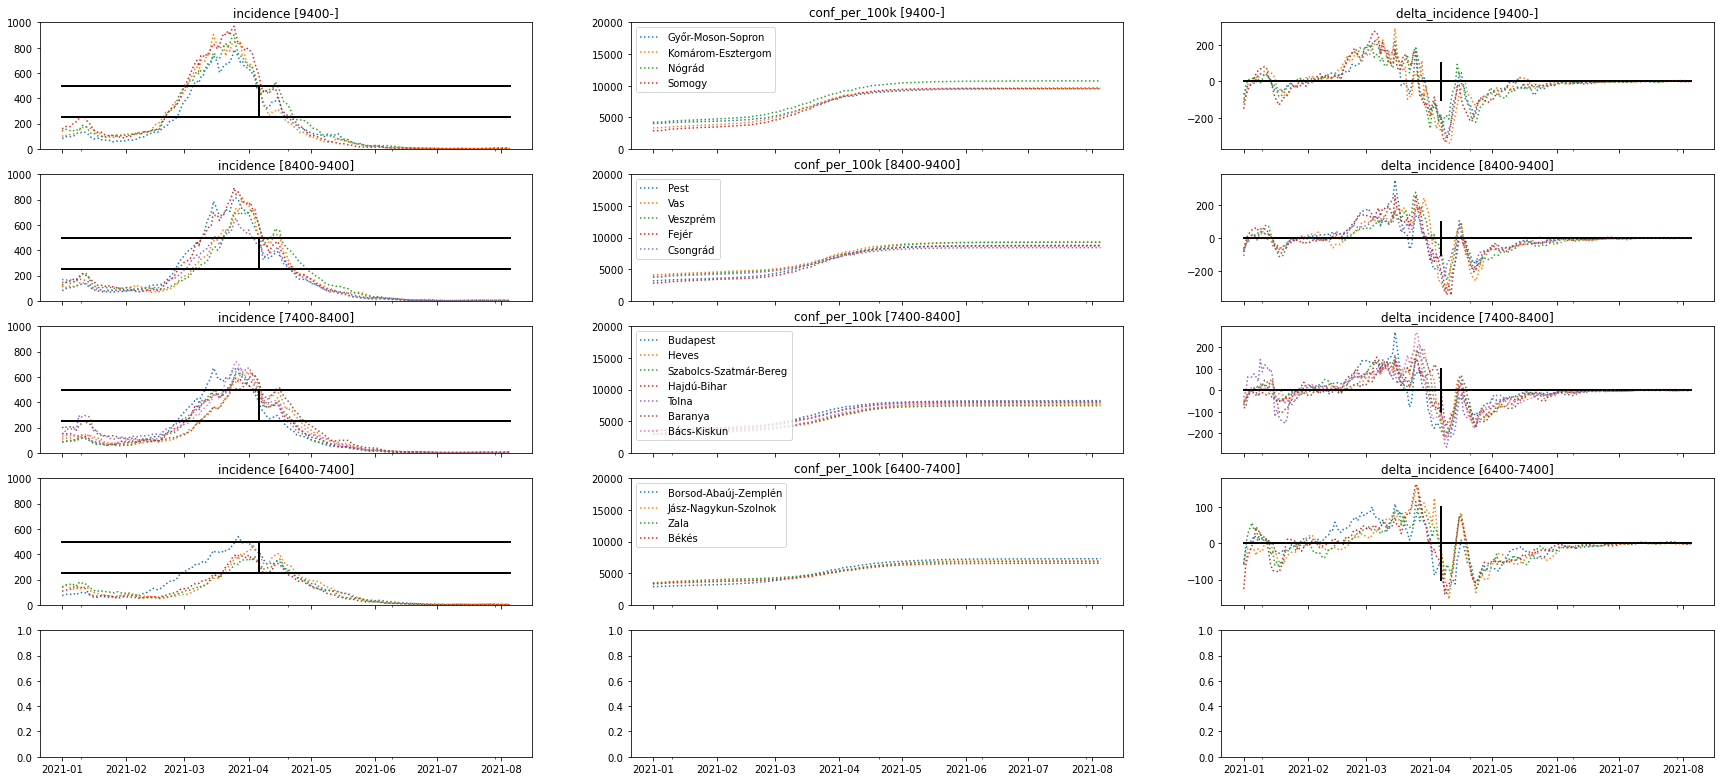

In [21]:
fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(30,15), sharex=True)
lims = [6400,7400,8400,9400]
for region in newBaseDf["region"].unique():
    plot_region(newBaseDf[(newBaseDf["date"]>="2021-01-01")], region, ax, lims)
plt.show()

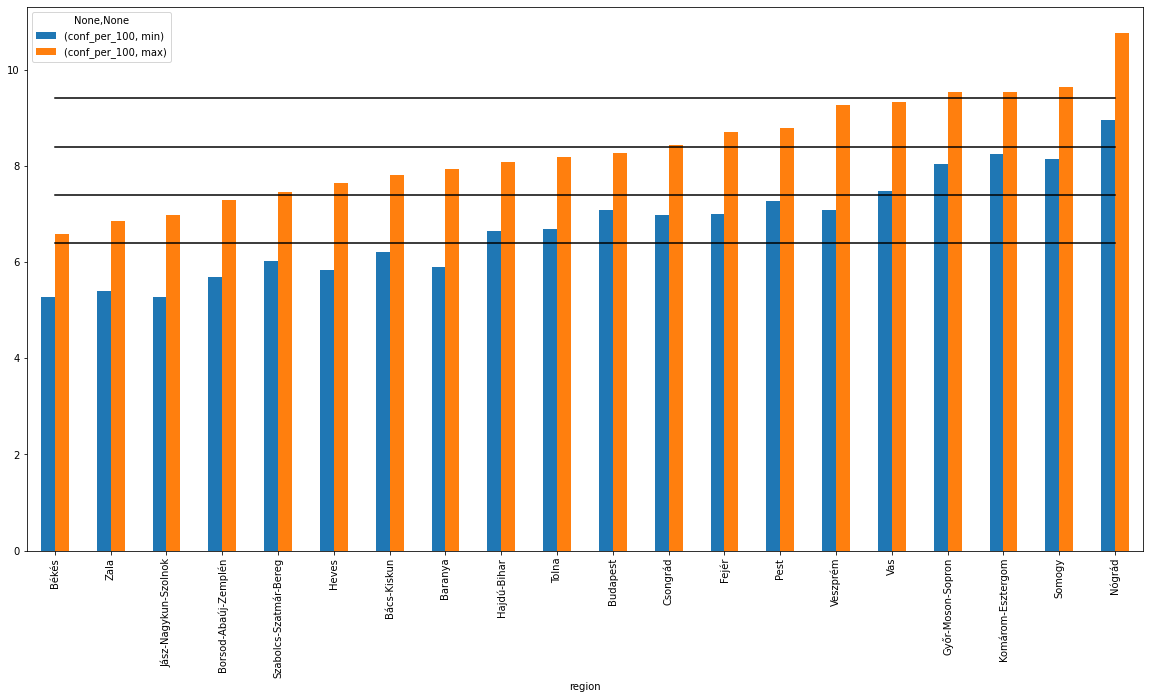

In [22]:
fig, ax = plt.subplots(figsize=(20,10))
for lim in lims:
    ax.plot((0, 19), (lim/1000, lim/1000), 'k-')
newBaseDf["conf_per_100"] = newBaseDf["conf_per_100k"]/1000
newBaseDf[(newBaseDf["date"]>="2021-04-01")].groupby(["region"]).agg(
    {"conf_per_100":["min","max"]}
).sort_values([("conf_per_100","max")]).plot.bar(ax=ax)
plt.show()